In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

In [2]:
!pip install ktrain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 31.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 64.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.6/653.6 kB 45.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 49.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Prepari

## Text Classification Example:  Sentiment Analysis with IMDb Movie Reviews

We will begin by importing some required modules for performing text classification in *ktrain*.

In [5]:
import ktrain
from ktrain import text
import tensorflow as tf

Next, we will load and preprocess the text data for training and validation.  *ktrain* can load texts and associated labels from a variety of source:

- `texts_from_folder`:  labels are represented as subfolders containing text files [ [example notebook] ](https://github.com/amaiya/ktrain/blob/master/examples/text/IMDb-BERT.ipynb)
- `texts_from_csv`: texts and associated labels are stored in columns in a CSV file [ [example notebook](https://github.com/amaiya/ktrain/blob/master/examples/text/toxic_comments-fasttext.ipynb) ]
- `texts_from_df`: texts and associated labels are stored in columns in a *pandas* DataFrame [ [example notebook](https://github.com/amaiya/ktrain/blob/master/examples/text/ArabicHotelReviews-nbsvm.ipynb) ]
- `texts_from_array`: texts and labels are loaded and preprocessed from an array [ [example notebook](https://github.com/amaiya/ktrain/blob/master/examples/text/20newsgroup-distilbert.ipynb) ]

For `texts_from_csv` and `texts_from_df`, labels can either be multi or one-hot-encoded with one column per class or can be a single column storing integers or strings like this:
```python
# my_training_data.csv
TEXT,LABEL
I like this movie,positive
I hate this movie,negative
```

For `texts_from_array`, the labels are arrays in one of the following forms:
```python
# string labels
y_train = ['negative', 'positive']
# integer labels
y_train = [0, 1]  # indices must start from 0
# multi or one-hot encoded labels (used for multi-label problems)
y_train = [[1,0], [0,1]]
```

In the latter two cases, you must supply a `class_names` argument to the `texts_from_array`, which tells *ktrain* how indices map to class names.  In this case, `class_names=['negative', 'positive']` because 0=negative and 1=positive.

Sample arrays for `texts_from_array` might look like this:
```python
x_train = ['I hate this movie.', 'I like this movie.']
y_train = ['negative', 'positive']
x_test = ['I despise this movie.', 'I love this movie.']
y_test = ['negative', 'positive']
```

All of the above methods transform the texts into a sequence of word IDs in one way or another, as expected by neural network models.


In this first example problem, we use the ```texts_from_folder``` function to load documents as fixed-length sequences of word IDs from a folder of raw documents.  This function assumes a directory structure like the following:

```
    ├── datadir
    │   ├── train
    │   │   ├── class0       # folder containing documents of class 0
    │   │   ├── class1       # folder containing documents of class 1
    │   │   ├── class2       # folder containing documents of class 2
    │   │   └── classN       # folder containing documents of class N
    │   └── test 
    │       ├── class0       # folder containing documents of class 0
    │       ├── class1       # folder containing documents of class 1
    │       ├── class2       # folder containing documents of class 2
    │       └── classN       # folder containing documents of class N
```

Each subfolder will contain documents in plain text format (e.g., `.txt` files) pertaining to the class represented by the subfolder.

For our text classification example, we will again classifiy IMDb movie reviews as either positive or negative.  However, instead of using the pre-processed version of the dataset pre-packaged with Keras, we will use the original (or raw) *aclImdb* dataset.  The dataset can be downloaded from [here](http://ai.stanford.edu/~amaas/data/sentiment/). Set the ```DATADIR``` variable to the location of the extracted *aclImdb* folder.

In the cell below, note that we supplied `preprocess_mode='standard'` to the data-loading function (which is the default).  For pretrained models like BERT and DistilBERT, the dataset must be preprocessed in a specific way.  If you are planning to use BERT for text classification, you should replace this argument with `preprocess_mode='bert'`. Since we will not be using BERT in this example, we leave it as `preprocess_mode='standard'`.  See [this notebook](https://github.com/amaiya/ktrain/blob/master/examples/text/IMDb-BERT.ipynb) for an example of how to use BERT for text classification in *ktrain*. There is also a [DistilBERT example notebook](https://github.com/amaiya/ktrain/blob/master/examples/text/20newsgroup-distilbert.ipynb).   
**NOTE:**  If using `preprocess_mode='bert'` or `preprocess_mode='distilbert'`, an English pretrained model is used for English, a Chinese pretrained model is used for Chinese, and a multilingual pretrained model is used for all other languages. For more flexibility in choosing the model used, you can use the alternative [Transformer API for text classification](https://github.com/amaiya/ktrain/blob/master/tutorials/tutorial-A3-hugging_face_transformers.ipynb) in *ktrain*.  

Please also note that, when specifying `preprocess_mode='distilbert'`, the first two return values are `TransformerDataset` objects, not Numpy arrays.  So, it is best to always use `trn, val, preproc` on the left-hand side of the expression (instead of `(x_train, y_train), (x_test, y_test_, preproc`) to avoid confusion, as shown below.

In [6]:
dataset = tf.keras.utils.get_file(fname="aclImdb_v1.tar.gz",
                                  origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
                                  extract=True)
IMDB_DATADIR = os.path.join(os.path.dirname(dataset), 'aclImdb')

84125825/84125825 [==============================] - 5s 0us/step


In [7]:
# load training and validation data from a folder

trn, val, preproc = text.texts_from_folder(IMDB_DATADIR, 
                                           max_features=80000, maxlen=2000, 
                                           ngram_range=3, 
                                           preprocess_mode='standard',
                                           classes=['pos', 'neg'])

detected encoding: utf-8
language: en
Word Counts: 88582
Nrows: 25000
25000 train sequences
train sequence lengths:
	mean : 237
	95percentile : 608
	99percentile : 923
Adding 3-gram features
max_features changed to 5151281 with addition of ngrams
Average train sequence length with ngrams: 709
train (w/ngrams) sequence lengths:
	mean : 709
	95percentile : 1821
	99percentile : 2766
x_train shape: (25000,2000)
y_train shape: (25000, 2)
Is Multi-Label? False
25000 test sequences
test sequence lengths:
	mean : 230
	95percentile : 584
	99percentile : 900
Average test sequence length with ngrams: 523
test (w/ngrams) sequence lengths:
	mean : 524
	95percentile : 1295
	99percentile : 1971
x_test shape: (25000,2000)
y_test shape: (25000, 2)


Having loaded the data, we will now create a text classification model.  The `print_text_classifier` function prints some available models.  The model selected should be consistent with the `preprocess_mode` selected above. 

(As mentioned above, one can also use the alternative `Transformer` API for text classification in *ktrain* to access an even larger library of Hugging Face Transformer models like RoBERTa and XLNet. See [this tutorial](https://github.com/amaiya/ktrain/blob/master/tutorials/tutorial-A3-hugging_face_transformers.ipynb) for more information on this.)   

In this example, the `text_classifier` function will return a [neural implementation of NBSVM](https://medium.com/@asmaiya/a-neural-implementation-of-nbsvm-in-keras-d4ef8c96cb7c), which is a strong baseline that can outperform more complex neural architectures. It may take a few moments to return as it builds a document-term matrix from the input data we provide it. The ```text_classifier```  function expects `trn` to be a preprocessed training set returned from the `texts_from*` function above. In this case where we have used `preprocess_mode='standard'`, `trn` is a numpy array with each document represented as fixed-size sequence of word IDs.

In [8]:
text.print_text_classifiers()

fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
logreg: logistic regression using a trainable Embedding layer
nbsvm: NBSVM model [http://www.aclweb.org/anthology/P12-2018]
bigru: Bidirectional GRU with pretrained fasttext word vectors [https://fasttext.cc/docs/en/crawl-vectors.html]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) from keras_bert [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face transformers [https://arxiv.org/abs/1910.01108]


In [9]:
# load an NBSVM model
model = text.text_classifier('nbsvm', trn, preproc=preproc)

Is Multi-Label? False
compiling word ID features...
maxlen is 2000
building document-term matrix... this may take a few moments...
rows: 1-10000
rows: 10001-20000
rows: 20001-25000
computing log-count ratios...
done.


Next, we instantiate a Learner object and call the ```lr_find``` and ```lr_plot``` methods to help identify a good learning rate.

In [10]:
learner = ktrain.get_learner(model, train_data=trn, val_data=val)

In [11]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
782/782 [==============================] - 60s 76ms/step - loss: 0.6614 - accuracy: 0.7014
Epoch 2/1024
782/782 [==============================] - 62s 79ms/step - loss: 0.8426 - accuracy: 0.9335
Epoch 3/1024
782/782 [==============================] - 0s 288us/step - loss: 5.1821 - accuracy: 0.9062


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


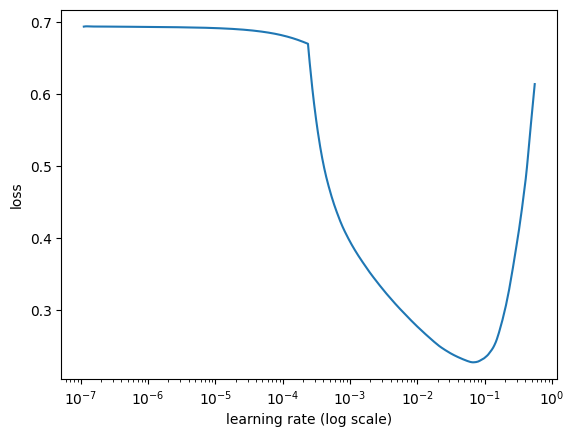

In [12]:
learner.lr_plot()

Finally, we will fit our model using and  [SGDR learning rate schedule](https://github.com/amaiya/ktrain/blob/master/example-02-tuning-learning-rates.ipynb) by invoking the ```fit``` method with the *cycle_len* parameter (along with the *cycle_mult* parameter).

In [13]:
learner.fit(0.001, 3, cycle_len=1, cycle_mult=2)

Epoch 1/7
782/782 [==============================] - 72s 91ms/step - loss: 0.2106 - accuracy: 0.9485 - val_loss: 0.2472 - val_accuracy: 0.9198
Epoch 2/7
782/782 [==============================] - 68s 87ms/step - loss: 0.0459 - accuracy: 0.9937 - val_loss: 0.2253 - val_accuracy: 0.9228
Epoch 3/7
782/782 [==============================] - 71s 90ms/step - loss: 0.0083 - accuracy: 0.9998 - val_loss: 0.2236 - val_accuracy: 0.9226
Epoch 4/7
782/782 [==============================] - 77s 99ms/step - loss: 0.0070 - accuracy: 0.9999 - val_loss: 0.2169 - val_accuracy: 0.9226
Epoch 5/7
782/782 [==============================] - 69s 88ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.2151 - val_accuracy: 0.9225
Epoch 6/7
782/782 [==============================] - 68s 87ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.2144 - val_accuracy: 0.9225
Epoch 7/7
782/782 [==============================] - 67s 86ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.2143 - val_accuracy: 0.9224

#### As can be seen, our final model yields a validation accuracy of 92.27%.

### Making Predictions

Let's predict the sentiment of new movie reviews (or comments in this case) using our trained model.

The ```preproc``` object (returned by ```texts_from_folder```) is important here, as it is used to preprocess data in a way our model expects.

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [ ]:
data = [ 'This movie was horrible! The plot was boring. Acting was okay, though.',
         'The film really sucked. I want my money back.',
        'What a beautiful romantic comedy. 10/10 would see again!']

In [ ]:
predictor.predict(data)

['neg', 'neg', 'pos']

As can be seen, our model returns predictions that appear to be correct. The predictor instance can also be used to return "probabilities" of our predictions with respect to each class.  Let us first print the classes and their order.  The class *pos* stands for positive sentiment and *neg* stands for negative sentiment. Then, we will re-run ```predictor.predict``` with *return_proba=True* to see the probabilities.

In [ ]:
predictor.get_classes()

['neg', 'pos']

In [ ]:
predictor.predict(data, return_proba=True)

array([[0.81179327, 0.18820675],
       [0.7463994 , 0.25360066],
       [0.26558533, 0.7344147 ]], dtype=float32)

For text classifiers, there is also `predictor.predict_proba`, which is simply calls `predict` with `return_proba=True`.

Our movie review sentiment predictor can be saved to disk and reloaded/re-used later as part of an application.  This is illustrated below:

In [ ]:
predictor.save('/tmp/my_moviereview_predictor')

In [ ]:
predictor = ktrain.load_predictor('/tmp/my_moviereview_predictor')

In [ ]:
predictor.predict(['Groundhog Day is my favorite movie of all time!'])

['pos']

Note that both the `load_predictor` and `get_predictor` functions accept an optional `batch_size` argument that is set to 32 by default. The `batch_size` can also be set manually on the `Predictor` instance.  That is, the `batch_size` used for inference and predictions can be increased with either of the following:
```python
# you can set the batch_size as an argument to load_predictor (or get_predictor)
predictor = ktrain.load_predictor('/tmp/my_moviereview_predictor', batch_size=128)

# you can also set the batch_size used for predictions this way
predictor.batch_size = 128
```
Larger batch sizes can potentially speed predictions when `predictor.predict` is supplied with a list of examples.

## Multi-Label Text Classification:  Identifying Toxic Online Comments

In the previous example, the classes (or categories) were mutually exclusive. By contrast, in multi-label text classification, a document or text snippet can belong to multiple classes. Here, we will classify Wikipedia comments into one or more categories of so-called *toxic comments*.   Categories of toxic online behavior include toxic, severe_toxic, obscene, threat, insult, and identity_hate.  The dataset can be downloaded from the [Kaggle Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data) as a CSV file (i.e., download the file ```train.csv```).  We will load the data using the ```texts_from_csv``` function.  This function expects one column to contain the texts of documents and one or more other columns to store the labels.  Labels can be in any of the following formats:

```
1. one-hot-encoded or arrays representing classes will have a single one in each row:
    Binary Classification (two classes):
         text|positive|negative
         I like this movie.|1|0
         I hated this movie.|0|1
   Multiclass Classification (more than two classes): 
         text|negative|neutral|positive
          I hated this movie.|1|0|0  # negative
          I loved this movie.|0|0|1 # positive
          I saw the movie.|0|1|0     # neutral
2. multi-hot-encoded arrays representing classes:
    Multi-label classification will have one or more ones in each row:
          text|politics|television|sports
          I will vote in 2020.|1|0|0  # politics
          I watched the debate on CNN.|1|1|0 # politics and television
          Did you watch the game on ESPN?|0|1|1     # sports and television
          I play basketball.|0|0|1     # sports    
3. labels are in a single column of string or integer values representing classs labels
   Example with label_columns=['label'] and text_column='text':
      text|label
      I like this movie.|positive
      I hated this movie.|negative
```

Since the Toxic Comment Classification Challenge is a multi-label problem, we must use the second format, where labels are already multi-hot-encoded. Luckily, the `train.csv` file for this problem is already multi-hot-encoded, so no extra processing is required.  

Since `val_filepath is None`, 10% of the data will automatically be used as a validation set.


In [14]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("drive/MyDrive/Colab Notebooks")

Mounted at /content/drive


In [19]:
DATA_PATH = 'ktrain tutorials/toxic_comments_train.csv'
NUM_WORDS = 50000
MAXLEN = 150
trn, val, preproc = text.texts_from_csv(DATA_PATH,
                     'comment_text',
                      label_columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"],
                      val_filepath=None, # if None, 10% of data will be used for validation
                      max_features=NUM_WORDS, maxlen=MAXLEN,
                      ngram_range=1)

detected encoding: utf-8 (if wrong, set manually)
['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
       toxic  severe_toxic  obscene  threat  insult  identity_hate
406        0             0        0       0       0              0
79182      0             0        0       0       0              0
51218      0             0        0       0       0              0
94830      0             0        0       0       0              0
12257      0             0        0       0       0              0
['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
        toxic  severe_toxic  obscene  threat  insult  identity_hate
145827      0             0        0       0       0              0
79574       0             0        0       0       0              0
151847      0             0        0       0       0              0
10315       0             0        0       0       0              0
57415       0             0        0       0       0        

Next, as before, we load a text classification model and wrap the model and data in Learner object.  Instead of using the NBSVM model, we will explicitly request a different model called fasttext using the ```name``` parameter of ```text_classifier```.  The fastText architecture was created by [Facebook](https://arxiv.org/abs/1607.01759) in 2016. (You can call the ```print_textmodels``` to show the available text classification models.) 

In [20]:
text.print_text_classifiers()

fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
logreg: logistic regression using a trainable Embedding layer
nbsvm: NBSVM model [http://www.aclweb.org/anthology/P12-2018]
bigru: Bidirectional GRU with pretrained fasttext word vectors [https://fasttext.cc/docs/en/crawl-vectors.html]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) from keras_bert [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face transformers [https://arxiv.org/abs/1910.01108]


In [21]:
model = text.text_classifier('fasttext', trn, preproc=preproc)
learner = ktrain.get_learner(model, train_data=trn, val_data=val)

Is Multi-Label? True
compiling word ID features...
maxlen is 150
done.


As before, we use our learning rate finder to find a good learning rate. In this case, a learning rate of 0.0007 appears to be good.

In [22]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
4488/4488 [==============================] - 99s 22ms/step - loss: 0.4925 - accuracy: 0.4241


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


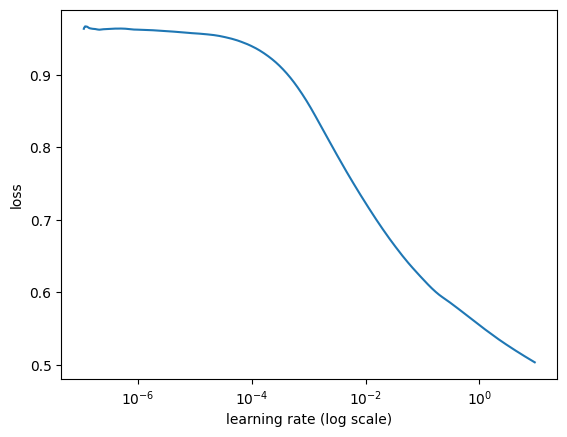

In [23]:
learner.lr_plot()

Finally, we will train our model for 8 epochs using ```autofit``` with a learning rate of 0.0007. Having explicitly specified the number of epochs, ```autofit``` will automatically employ a triangular learning rate policy. Our final ROC-AUC score is **0.98**.

As shown in [this example notebook](https://github.com/amaiya/ktrain/blob/master/examples/text/toxic_comments-bigru.ipynb) on our GitHub project, even better results can be obtained using a Bidirectional GRU with pretrained word vectors (called ‘bigru’ in ktrain)

In [24]:
learner.autofit(0.0007, 8)



begin training using triangular learning rate policy with max lr of 0.0007...
Epoch 1/8
4488/4488 [==============================] - 252s 56ms/step - loss: 0.1712 - accuracy: 0.6533 - val_loss: 0.0552 - val_accuracy: 0.9944
Epoch 2/8
4488/4488 [==============================] - 229s 51ms/step - loss: 0.0664 - accuracy: 0.9788 - val_loss: 0.0522 - val_accuracy: 0.9944
Epoch 3/8
4488/4488 [==============================] - 229s 51ms/step - loss: 0.0587 - accuracy: 0.9934 - val_loss: 0.0506 - val_accuracy: 0.9944
Epoch 4/8
4488/4488 [==============================] - 235s 52ms/step - loss: 0.0551 - accuracy: 0.9938 - val_loss: 0.0493 - val_accuracy: 0.9944
Epoch 5/8
4488/4488 [==============================] - 229s 51ms/step - loss: 0.0527 - accuracy: 0.9933 - val_loss: 0.0492 - val_accuracy: 0.9944
Epoch 6/8
4488/4488 [==============================] - 229s 51ms/step - loss: 0.0505 - accuracy: 0.9932 - val_loss: 0.0488 - val_accuracy: 0.9944
Epoch 7/8
4488/4488 [=======================

#### Let's compute for ROC-AUC of our final model for identifying toxic online behavior:

In [25]:
from sklearn.metrics import roc_auc_score
y_pred = learner.model.predict(x_test, verbose=0)
score = roc_auc_score(y_test, y_pred)
print("\n ROC-AUC score: %.6f \n" % (score))

NameError: ignored

### Making Predictions

As before, let's make some predictions about toxic comments using our model by wrapping it in a Predictor instance.

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [ ]:
# correctly predict a toxic comment that includes a threat
predictor.predict(["If you don't stop immediately, I will kill you."])

[[('toxic', 0.5491581),
  ('severe_toxic', 0.02454061),
  ('obscene', 0.084347874),
  ('threat', 0.4110818),
  ('insult', 0.17229997),
  ('identity_hate', 0.08519211)]]

In [ ]:
# non-toxic comment
predictor.predict(["Okay - I'm calling it a night. See you tomorrow."])

[[('toxic', 0.021799222),
  ('severe_toxic', 7.991817e-07),
  ('obscene', 0.000504758),
  ('threat', 5.477591e-05),
  ('insult', 0.001496369),
  ('identity_hate', 9.472556e-05)]]

In [ ]:
predictor.save('/tmp/toxic_detector')

In [ ]:
predictor = ktrain.load_predictor('/tmp/toxic_detector')

In [ ]:
# model works correctly and as expected after reloading from disk
predictor.predict(["You have a really ugly face."])

[[('toxic', 0.86799675),
  ('severe_toxic', 0.008107864),
  ('obscene', 0.26740596),
  ('threat', 0.006626291),
  ('insult', 0.39607796),
  ('identity_hate', 0.023489485)]]

## The `Transformers` API in *ktrain*

If using transformer models like BERT or DistilBert or RoBERTa, *ktrain* includes an alternative API for text classification, which allows the use of **any** Hugging Face `transformers` model.  This API can be used as follows:

```python
import ktrain
from ktrain import text
MODEL_NAME = 'bert-base-uncased'
t = text.Transformer(MODEL_NAME, maxlen=500,  
                     classes=label_list)
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)
learner.fit_onecycle(3e-5, 1)
```

Note that `x_train` and `x_test` are the raw texts here:
```python
x_train = ['I hate this movie.', 'I like this movie.']
```
Similar to `texts_from_array`, the labels are arrays in one of the following forms:
```python
# string labels
y_train = ['negative', 'positive']
# integer labels
y_train = [0, 1]
# multi or one-hot encoded labels
y_train = [[1,0], [0,1]]
```
In the latter two cases, you must supply a `class_names` argument to the `Transformer` constructor, which tells *ktrain* how indices map to class names.  In this case, `class_names=['negative', 'positive']` because 0=negative and 1=positive.

For an example, see [this notebook](https://nbviewer.jupyter.org/github/amaiya/ktrain/blob/master/examples/text/ArabicHotelReviews-AraBERT.ipynb), which builds and Arabic sentiment analysis model using [AraBERT](https://huggingface.co/aubmindlab/bert-base-arabert).


For more information, see our tutorial on [text classification with Hugging Face Transformers](https://github.com/amaiya/ktrain/blob/master/tutorials/tutorial-A3-hugging_face_transformers.ipynb).

You may be also interested in some of our blog posts on text classification:
- [Text Classification With Hugging Face Transformers in TensorFlow 2 (Without Tears)](https://towardsdatascience.com/text-classification-with-hugging-face-transformers-in-tensorflow-2-without-tears-ee50e4f3e7ed)
- [BERT Text Classification in 3 Lines of Code](https://towardsdatascience.com/bert-text-classification-in-3-lines-of-code-using-keras-264db7e7a358)